# Spray width from PMDI CFD

Dr Daniel Duke

Department of Mechanical & Aerospace Engineering

Monash University

## Imports

In [10]:
import numpy as np
import time, os, glob
import vtk
from vtk.util import numpy_support
import scipy.special
import scipy.optimize

%matplotlib widget
import matplotlib.pyplot as plt

## Functions to read CFD data and extract spray width as a function of streamwise location

In [15]:
def read_vtk(filename):
    t0 = time.perf_counter()
    sz = os.path.getsize(filename)
    reader = vtk.vtkXMLUnstructuredGridReader()
    reader.SetFileName(filename)
    reader.Update()
    output = reader.GetOutput()
    t1 = time.perf_counter()
    print("%s: read %0.1f MiB in %0.1f s" % (os.path.basename(filename),sz/1048576,t1-t0))

    # get the coordinates into human-readable variable names
    coords = numpy_support.vtk_to_numpy(output.GetPointData().GetArray('Coords'))
    radius = coords[:,0]
    theta = coords[:,1]
    z = coords[:,2]

    # Read a variable to use to evaluate spray width
    v = numpy_support.vtk_to_numpy(output.GetPointData().GetArray('yMean'))
    v = 1-v
    
    return radius, theta, z, v

In [19]:
# Fit erfc to the mixing layer to 1-y(r) at each z position.
# Use this least-squares fit to find the threshold.
def erfc_func(z,b,c):
   return 0.5*(scipy.special.erf(b*z+c)+1)

# calculate spray width based on fitting to unstructured grid points at various streamwise locations.
def calculate_width(radius, theta, z, v, threshold=0.5, func=erfc_func):
    t0 = time.perf_counter()
    
    # divide z domain up into pieces that have sufficient samples in each.
    # z_bins shows the z axis mid-points, and i_bins has a list of indices that fit into each.
    dz_min = 5e-5
    min_samples=2000
    z_bins = []
    i_bins = []
    zm = z.min()
    while zm <= z.max():
        #for zm in np.arange(z.min(),z.max(),dz):
        dz=dz_min
        flt = (z>zm-dz/2)&(z<zm+dz/2)
        while np.sum(flt)<min_samples:
            dz*=2
            flt = (z>zm-dz/2)&(z<zm+dz/2)
        z_bins.append(zm)
        i_bins.append(flt)
        zm += dz/2 + dz_min
    z_bins=np.array(z_bins)

    # radii for interpolation
    r__ = np.linspace(0,radius.max(),1024)
    width = []
    wall = []
    
    for i in range(len(i_bins)):
    
        # Slice radius, 1-y data.
        r_ = radius[(i_bins[i])]
        v_ = v[(i_bins[i])]
    
        wall.append(np.nanmax(r_))
        
        if ~np.any(v_<threshold): # there must be a mixing layer
            width.append(np.nan)
        else:
            # Least-squares
            popt, pcov = scipy.optimize.curve_fit(func, r_, v_)
        
            # Interpolate to find threshold for width
            evaluatedFunction = func(r__,*popt)
            w__ = np.interp(threshold, evaluatedFunction[::-1], r__[::-1]) # must be monotonically increasing, so reversed.
            width.append( w__ )
            
    # convert arrays.
    t1=time.perf_counter()
    print(" -> width calculation complete in %.1f s" % (t1-t0))
    return np.array(z_bins), np.array(width), np.array(wall)

## Loop through all files and calculate width

In [145]:
results={}
t_start=time.perf_counter()
for vtu_data in glob.glob('*/*.vtu'):
    if not 'EtOH' in vtu_data:
        radius, theta, z, v = read_vtk(vtu_data)
        z_, width, wall = calculate_width(radius, theta, z, v, threshold=0.85)
        results[os.path.basename(vtu_data)]=(z_, width, wall)
print("Total calculation complete in %.1f s" % (time.perf_counter()-t_start))

les_pmdimv2_0.33x1.2_ures_134a_smi_0_0.vtu: read 1468.1 MiB in 13.4 s
 -> width calculation complete in 9.2 s
les_pmdimv2_0.33x1.2_ures_227ea_0_0.vtu: read 1609.7 MiB in 14.5 s
 -> width calculation complete in 9.3 s
les_pmdimv2_0.33x1.2_ures_152a_smi_0_0.vtu: read 1673.7 MiB in 15.0 s
 -> width calculation complete in 8.8 s
les_pmdimv2_0.33x1.2_ures_1234ze_smi_0_0.vtu: read 1372.0 MiB in 12.5 s
 -> width calculation complete in 9.0 s
Total calculation complete in 92.3 s


Make plot

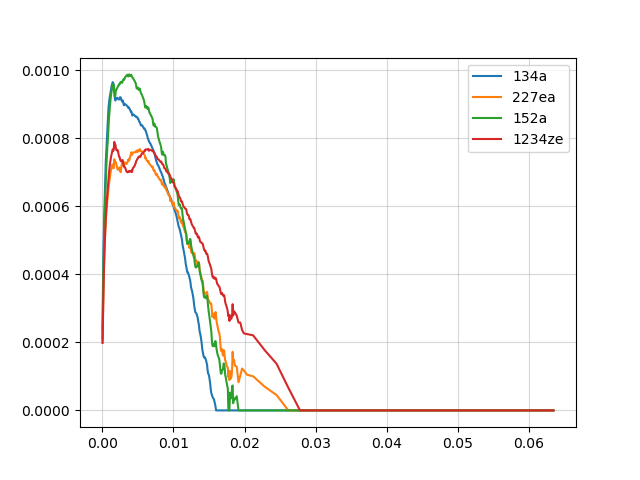

In [146]:
figure=plt.figure()
for k in results.keys():
    z_, width, wall = results[k]
    plt.plot(z_, width, label=os.path.basename(k).split('_')[4])
#plt.xscale('log');
plt.legend();
plt.grid(alpha=.5);

## Compare results to experiment

### Experimental data imported from MATLAB

In [127]:
D=0.33e-3
L=1.2e-3

expt={'134a':np.array([
    0.3399,    0.7142,
    1.4661,    1.5736,
    2.8450,    2.1426,
    3.8399,    2.3927,
    5.4146,    2.5961,
    6.9999,    2.7550,
    8.5976,    2.8615,
   10.1753,    3.0047,
   11.7683,    3.1172,
   14.5349,    3.1855,
   18.9386,    3.4024,
   21.3139,    3.4390,
   23.6781,    3.4472,
   26.0706,    3.6337,
   30.3906,    4.2241,
   33.1311,    4.4595,
   35.8777,    4.7291,
   38.6037,    5.0554,
   41.3564,    5.3407,
])}

expt['1234ze']=np.array([
    0.3704,    0.8844,
    1.4812,    1.8721,
    2.8431,    2.3995,
    3.8532,    2.6841,
    5.4429,    2.9654,
    7.0370,    3.2474,
    8.6452,    3.4285,
   10.2400,    3.5524,
   11.8350,    3.6409,
   14.5741,    3.7785,
   19.2151,    4.1120,
   21.7409,    4.2385,
   24.2518,    4.3197,
   26.7910,    4.6070,
   31.6654,    5.4682,
   34.6391,    5.8751,
   37.6131,    6.2940,
   40.5573,    6.7126,
   43.5312,    7.0396,
])

expt['152a']=np.array([
    0.3399,    0.7326,
    1.4517,    1.6728,
    2.8277,    2.2738,
    3.8634,    2.5504,
    5.4717,    2.8387,
    7.0891,    3.0778,
    8.7152,    3.2540,
   10.3267,    3.4765,
   11.9383,    3.6939,
   14.5663,    3.9343,
   19.2356,    4.4621,
   21.7881,    4.7255,
   24.3253,    4.9539,
   26.8926,    5.2616,
   31.5087,    6.2309,
   34.5031,    6.6828,
   37.4975,    7.1547,
   40.4613,    7.6712,
   43.4557,    8.2424,
])

expt['152aSus']=np.array([
    0.3092,    1.6411,
    1.3568,    1.8929,
    2.7965,    2.2790,
    3.8412,    2.5560,
    5.4737,    2.7998,
    7.1071,    3.0088,
    8.7557,    3.1962,
   10.3738,    3.4705,
   12.0072,    3.6728,
   14.7198,    3.9103,
   19.4396,    4.4977,
   21.9980,    4.7475,
   24.5411,    4.9654,
   27.1149,    5.3116,
   31.7726,    6.0688,
   34.7647,    6.4625,
   37.7568,    6.8873,
   40.7182,    7.3445,
   43.7103,    7.8994,
])

expt['134aSus']=np.array([
    0.3092,    0.6967,
    1.4149,    1.5353,
    2.8073,    2.1042,
    3.7962,    2.3208,
    5.3999,    2.5463,
    7.0128,    2.7300,
    8.6332,    2.8570,
   10.2394,    2.9733,
   11.8541,    3.0774,
   14.5906,    3.1664,
   19.2704,    3.4980,
   21.8042,    3.6620,
   24.3231,    3.7978,
   26.8718,    4.0380,
   31.6133,   4.8685,
   34.5856,   5.2043,
   37.5625,   5.5656,
   40.5111,    5.9267,
   43.4903,    6.3112,
])

expt['1234zeSus']=np.array([
    0.3092,    0.6967,
    1.4149,    1.5353,
    2.8073,    2.1042,
    3.7962,    2.3208,
    5.3999,    2.5463,
    7.0128,    2.7300,
    8.6332,    2.8570,
   10.2394,    2.9733,
   11.8541,    3.0774,
   14.5906,    3.1664,
   19.2704,    3.4980,
   21.8042,    3.6620,
   24.3231,    3.7978,
   26.8718,    4.0380,
   31.6133,    4.8685,
   34.5856,    5.2043,
   37.5625,    5.5656,
   40.5111,    5.9267,
   43.4903,    6.3112,
])

### Make plot

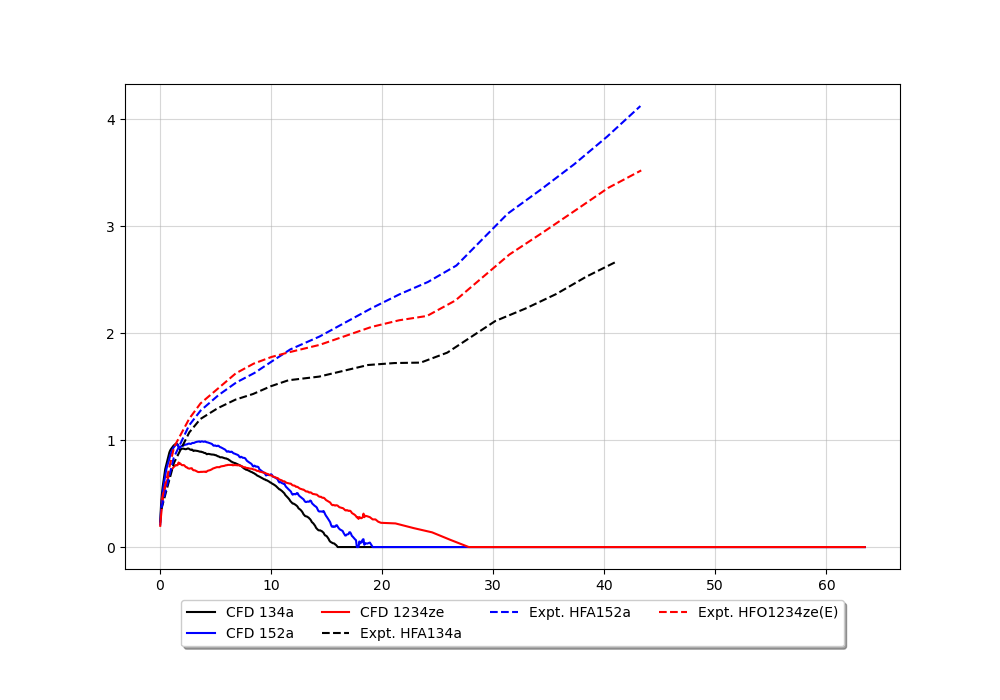

In [147]:
# CFD data
figure=plt.figure(figsize=(10,7))
for k in results.keys():
    z_, width, wall = results[k]
    form = '_'.join(os.path.basename(k).split('_')[4:-2])
    if '134' in form: c='k'
    elif '152' in form: c='b'
    elif '1234' in form: c='r'
    elif '227' in form: c='g'
    else: c=None
    form = form.replace('_smi','')
    if not 'EtOH' in form: 
        if not '227' in form:
            plt.plot(z_*1e3, 1e3*width, label='CFD '+form, c=c)

# Add experimental spray half-width
plt.plot(expt['134a'][::2]  -0.2 , .5*expt['134a'][1::2], c='k', ls='--', label='Expt. HFA134a')
plt.plot(expt['152a'][::2]  -0.2, .5*expt['152a'][1::2], c='b', ls='--', label='Expt. HFA152a')
plt.plot(expt['1234ze'][::2]-0.2, .5*expt['1234ze'][1::2], c='r', ls='--', label='Expt. HFO1234ze(E)')
'''
plt.plot(expt['134aSus'][::2]  -0.2 , .5*expt['134aSus'][1::2], c='k', ls='-.', alpha=.5, label='Expt. HFA134a SS')
plt.plot(expt['152aSus'][::2]  -0.2, .5*expt['152aSus'][1::2], c='b', ls='-.', alpha=.5, label='Expt. HFA152a SS')
plt.plot(expt['1234zeSus'][::2]-0.2, .5*expt['1234zeSus'][1::2], c='r', ls='-.', alpha=.5, label='Expt. HFO1234ze(E) SS')
'''

#plt.xscale('log');
#plt.legend();
plt.grid(alpha=.5);
#plt.xlim(-1,25);
#plt.ylim(0,2.5);

# Shrink current axis's height by 10% on the bottom
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=4);